# Semantic Segmentation
We’ll work with the Oxford-IIIT Pets dataset (www.robots.ox.ac.uk/~vgg/data/pets/), which contains 7,390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture. A **segmentation mask** is the image-segmentation equivalent of a label: it’s an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the input image. In our case, the pixels of our segmentation masks can take one of three integer values:

1. (foreground)

2. (background)

3. (contour)


In [21]:
import os

input_dir = "data/image_segmentation/images/"
target_dir = "data/image_segmentation/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

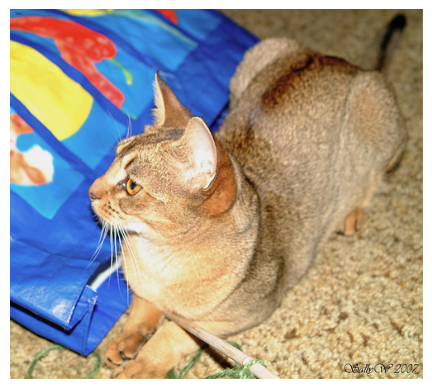

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

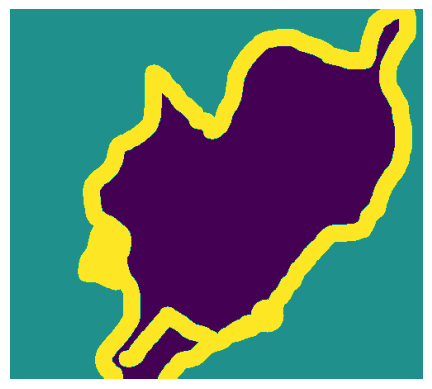

In [23]:
def display_target(target_array):
    # The original labels are 1, 2, and 3. We subtract 1 so that the labels range from 0 to 2, and then we multiply by 127 so that the labels become 0 (black), 127 (gray), 254 (near-white).
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])


img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

Next, let’s load our inputs and targets into two NumPy arrays, and let’s split the arrays into a training and a validation set. Since the dataset is very small, we can just load everything into memory.

In [24]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))


def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img


input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [25]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax",
                            padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

The first half of the model closely resembles the kind of convnet you’d use for image classification: a stack of Conv2D layers, with gradually increasing filter sizes. We downsample our images three times by a factor of two each, ending up with activations of size (25, 25, 256). The purpose of this first half is to encode the images into smaller feature maps, where each spatial location (or pixel) contains information about a large spatial chunk of the original image. You can understand it as a kind of compression.

One important difference between the first half of this model and the classification models you’ve seen before is the way we do downsampling: in the classification convnets from the last chapter, we used MaxPooling2D layers to downsample feature maps. Here, we downsample by adding strides to every other convolution layer. **We do this because, in the case of image segmentation, we care a lot about the spatial location of information in the image, since we need to produce per-pixel target masks as output of the model**. When you do 2 × 2 max pooling, you are completely destroying location information within each pooling window: you return one scalar value per window, with zero knowledge of which of the four locations in the windows the value came from. **So while max pooling layers perform well for classification tasks, they would hurt us quite a bit for a segmentation task.** 

Meanwhile, strided convolutions do a better job at downsampling feature maps while retaining location information. Throughout this book, you’ll notice that we tend to use strides instead of max pooling in any model that cares about feature location, such as the generative models in chapter 12.

The second half of the model is a stack of Conv2DTranspose layers. What are those? Well, the output of the first half of the model is a feature map of shape (25, 25, 256), but we want our final output to have the same shape as the target masks, (200, 200, 3). Therefore, we need to apply a kind of inverse of the transformations we’ve applied so far—something that will upsample the feature maps instead of downsampling them.

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")
callbacks = [keras.callbacks.ModelCheckpoint("models/oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=20, batch_size=64, callbacks=callbacks,
                    validation_data=(val_input_imgs, val_targets))


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 1.0836 - val_loss: 1.0503
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - loss: 1.0421 - val_loss: 1.0145
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - loss: 1.0069 - val_loss: 0.9861
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - loss: 0.9807 - val_loss: 0.9638
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.9602 - val_loss: 0.9474
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - loss: 0.9462 - val_loss: 0.9362
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - loss: 0.9355 - val_loss: 0.9298
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 0.9291 - val_loss: 0.9268
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 0.9326 - val_loss: 0.9258
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.9289 - val_loss: 0.9257
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.9297 - val_loss: 0.9257
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

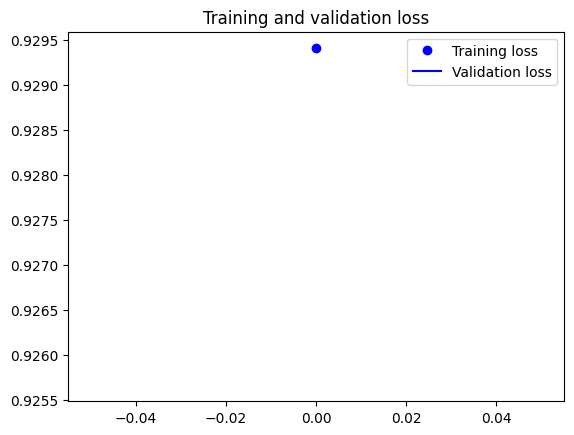

In [42]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(list(range(1)), loss, "bo", label="Training loss")
plt.plot(list(range(1)), val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


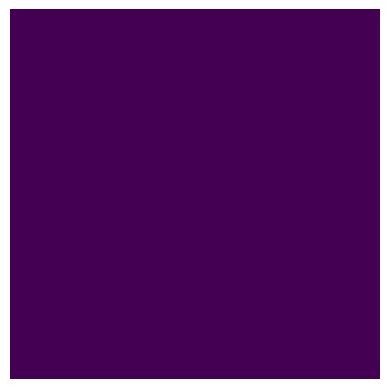

In [47]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("models/oxford_segmentation.keras")

i = 12
test_image = val_input_imgs[i]
plt.axis("off")
# plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]


def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)


display_mask(mask)

## Modern convnet architecture patterns

In [23]:
# Modularity, Hierarchy, and Reuse

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1. / 255)(inputs)


def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x


x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 32, 32, 3) │          0 │ input_layer_25[0… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │        896 │ rescaling_6[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_82[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 16, 16,    │        128 │ rescaling_6[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 16, 16,    │          0 │ max_pooling2d_16… │
│                     │ 32)               │            │ conv2d_84[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 16, 16,    │     18,496 │ add_31[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_85[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 8, 64)  │          0 │ conv2d_86[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 8, 8, 64)  │          0 │ max_pooling2d_17… │
│                     │                   │            │ conv2d_87[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_88[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 8, 8, 128) │          0 │ conv2d_89[0][0],  │
│                     │                   │            │ conv2d_90[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_33[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## 9.3.5 Putting it together: A mini Xception-like model
- Your model should be organized into repeated blocks of layers, usually made of multiple convolution layers and a max pooling layer.
- The number of filters in your layers should increase as the size of the spatial feature maps decreases.
- Deep and narrow is better than broad and shallow.
- Introducing residual connections around blocks of layers helps you train deeper networks.
- It can be beneficial to introduce batch normalization layers after your convolution layers.
- It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.


In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, padding="same", use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_23[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 180, 180,  │          0 │ sequential_2[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 180, 180,  │      2,400 │ rescaling_5[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 180,  │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 180, 180,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_10 │ (None, 180, 180,  │      1,312 │ activation_10[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 180,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 180, 180,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_11 │ (None, 180, 180,  │      1,312 │ activation_11[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 90, 90,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 90, 90,    │      1,024 │ conv2d_76[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 90, 90,    │          0 │ max_pooling2d_11… │
│                     │ 32)               │            │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        128 │ add_26[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 90, 90,    │      2,336 │ activation_12[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

## Interpreting What Convnets Learn

### Visualizing intermediate activations

In [24]:
# loading a model we used before
from tensorflow import keras

model = keras.models.load_model("models/convnet_from_scratch.keras")
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [72]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)


def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a “batch” of a single sample. Its shape is now (1, 180, 180, 3)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path, (180, 180))
img_tensor.shape

(1, 180, 180, 3)

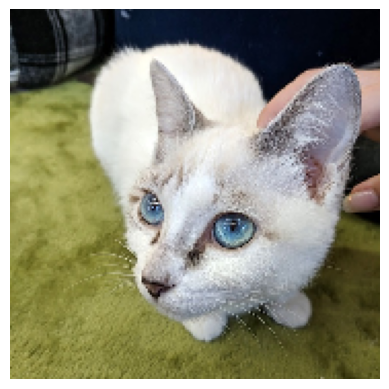

In [73]:
import matplotlib.pyplot as plt

# plotting the image
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [81]:
# In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)  # this is called the feature extraction model
# outputs=layer_outputs. This specifies that the outputs of activation_model are the outputs of selected intermediate layers (e.g., convolutional and pooling layers) of the original model.

In [87]:
activations = activation_model.predict(img_tensor)
len(activations)  # we have activations of 10 layers of two types, Conv2D and MaxPooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


10

In [76]:
# It’s a 178 × 178 feature map with 32 channels. 
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 178, 178, 32)

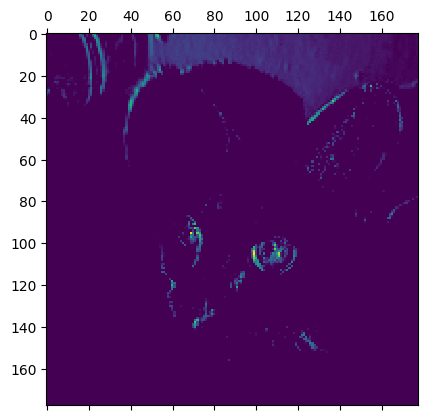

In [77]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

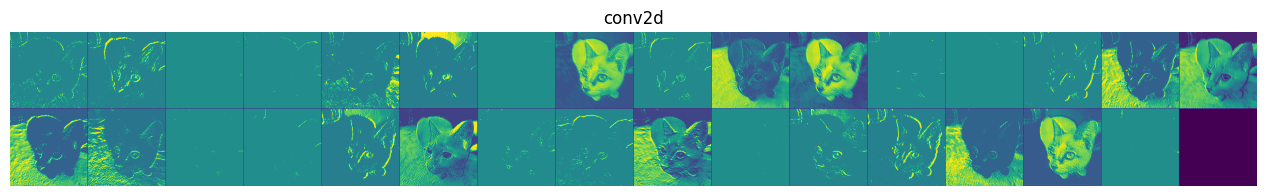

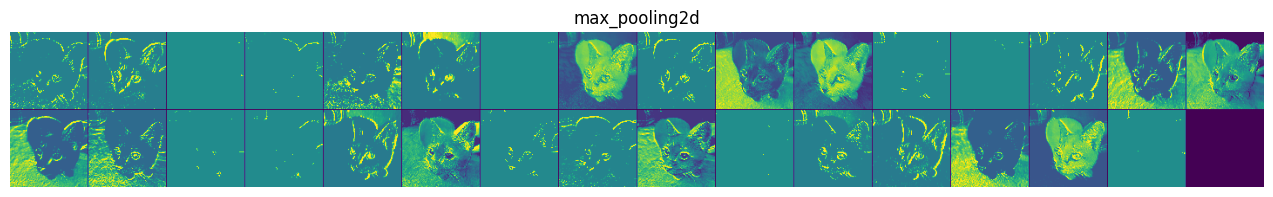

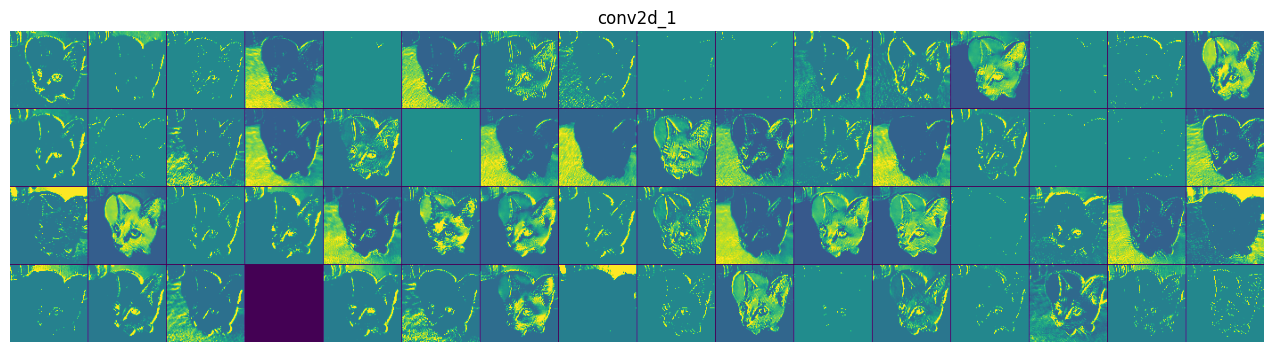

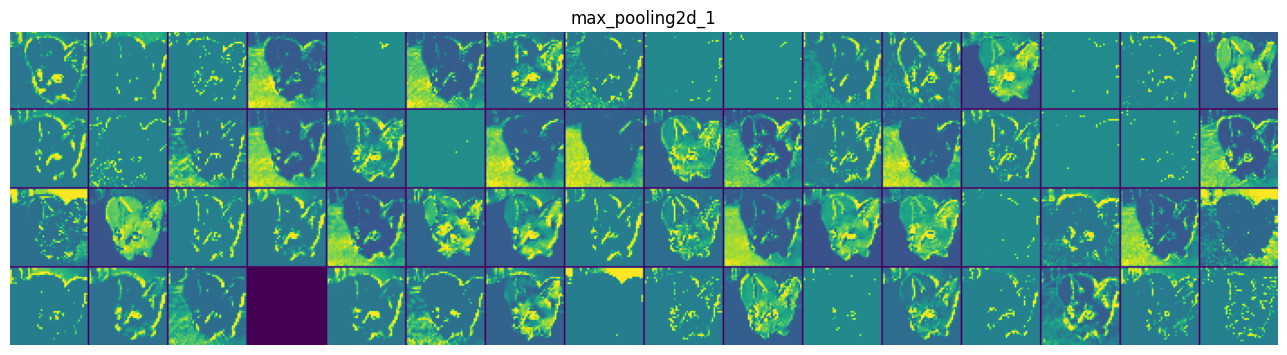

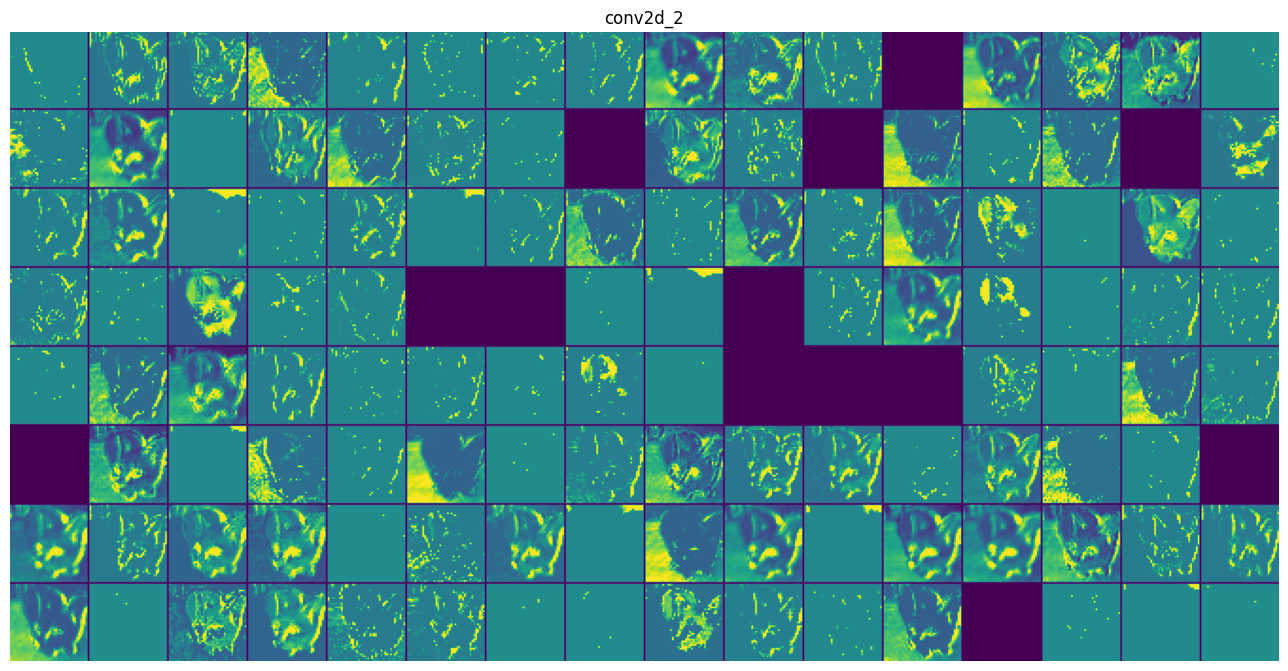

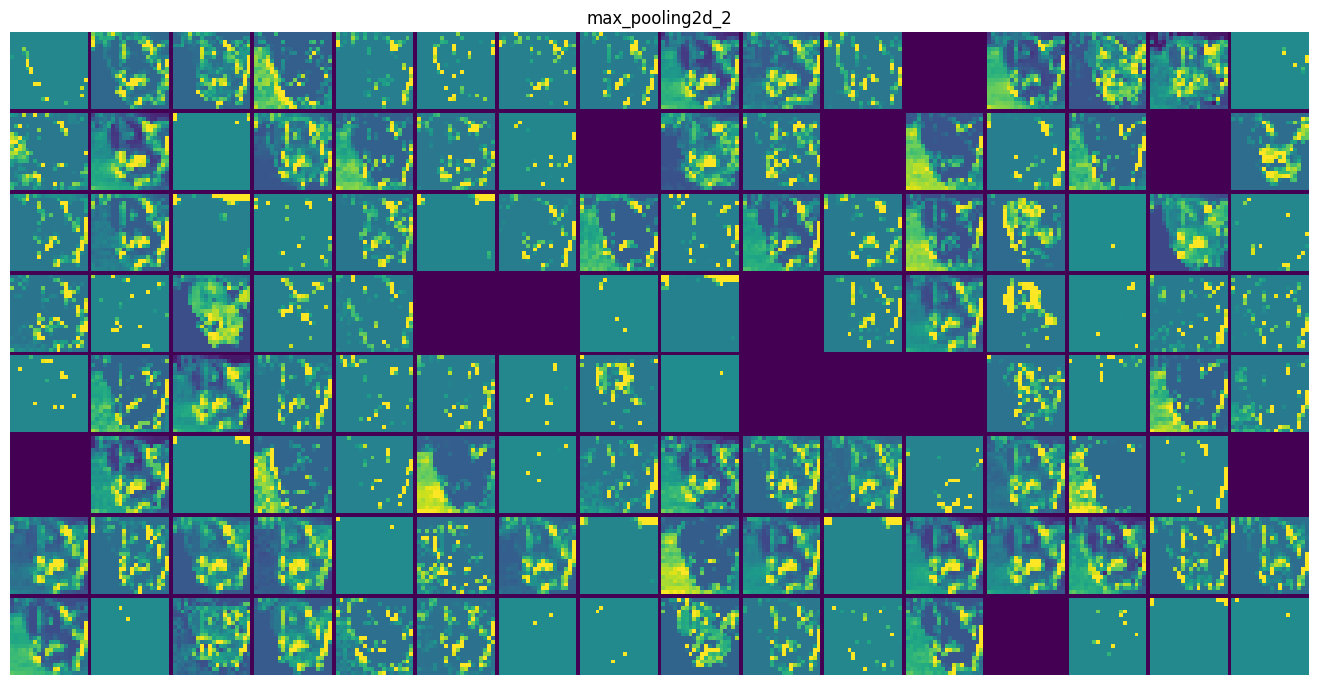

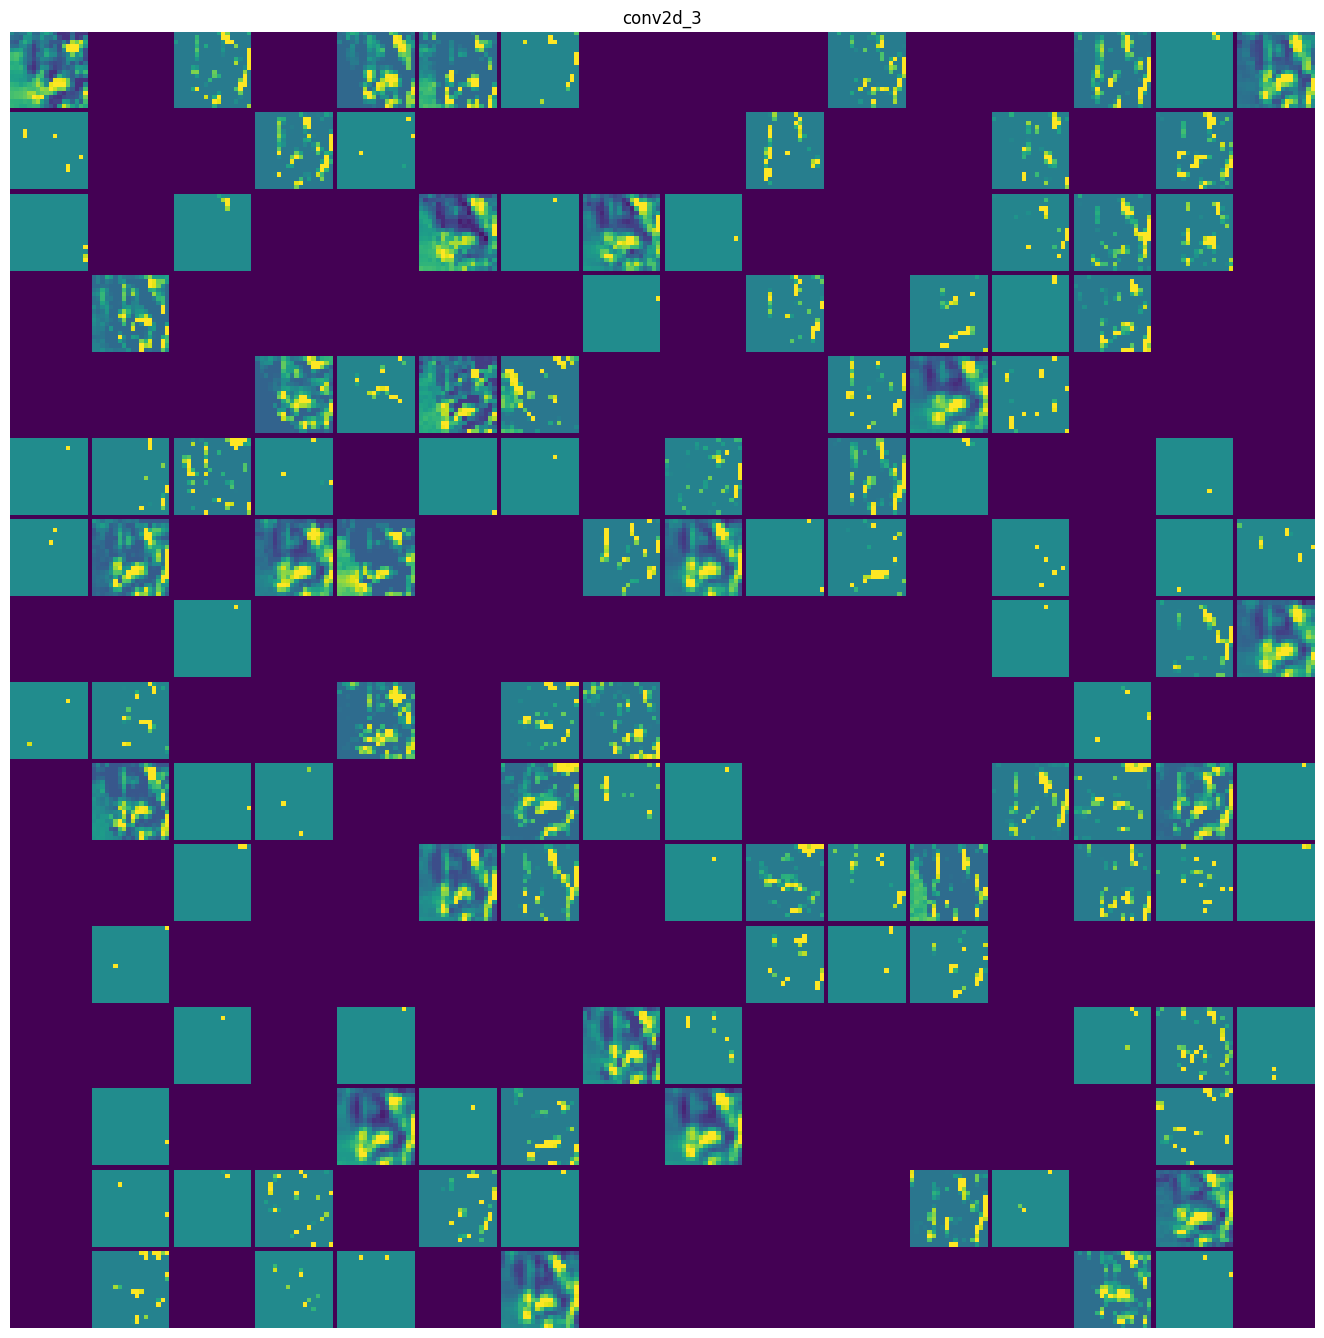

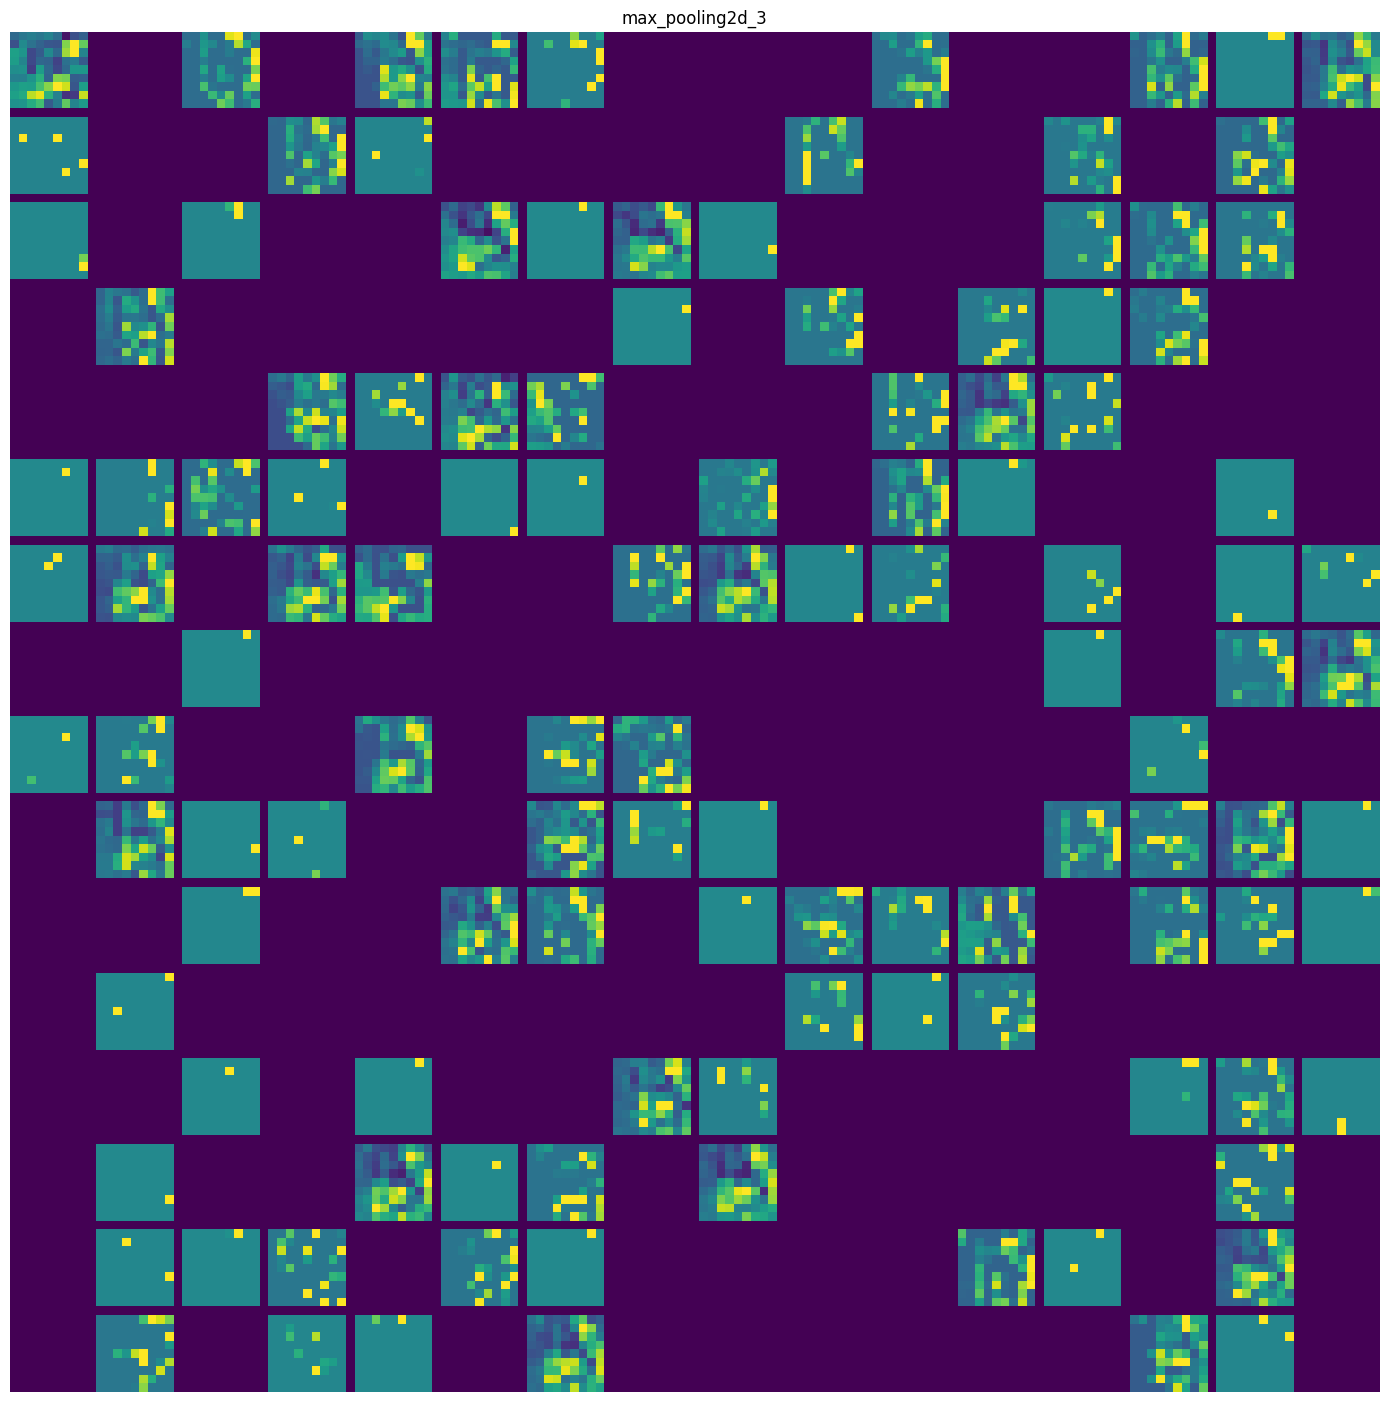

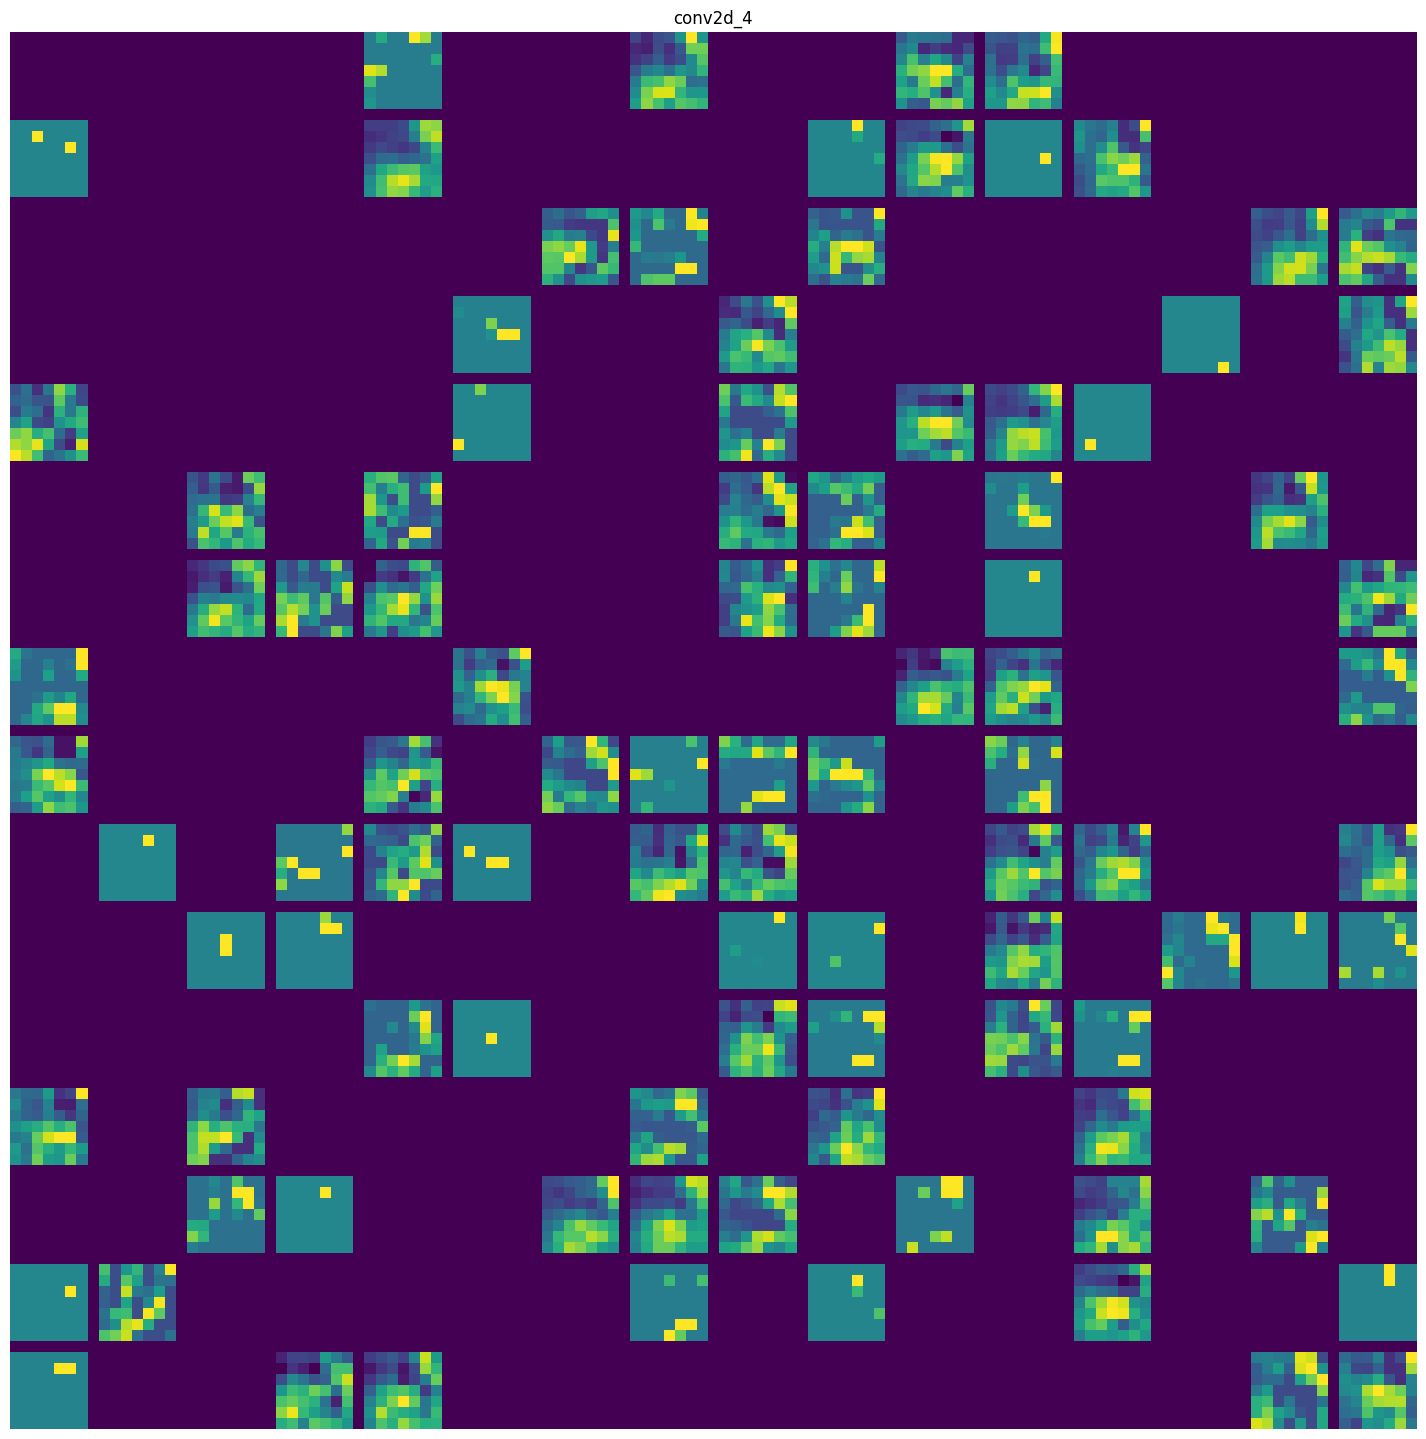

In [78]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
            col * (size + 1): (col + 1) * size + col,
            row * (size + 1): (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

NOTES:
- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.

- As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Deeper presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.

- The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.


A deep neural network effectively acts as an **information distillation pipeline**


## Visualizing Convnet Filters (Gradient Ascent process)
The process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. 

In [79]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)  # removing the classification layer

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [120]:
# We’re interested in the convolutional layers of the model—the Conv2D and SeparableConv2D layers. We’ll need to know their names.
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_91
block3_sepconv1
block3_sepconv2
conv2d_92
block4_sepconv1
block4_sepconv2
conv2d_93
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_94
block14_sepconv1
block14_sepconv2


In [121]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
# Feature extractor model: We use model.input and layer.output to create a model that, given an input image, returns the output of our target layer
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [122]:
# To use this model, simply call it on some input data 
# note that Xception requires inputs to be preprocessed via the keras.applications.xception.preprocess_input function
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)
activation.shape

TensorShape([1, 49, 49, 256])

In [123]:
import tensorflow as tf


# This function returns a scalar value quantifying how much a given input image “activates” a given filter in the layer.
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2,
                        filter_index]  # Avoid border artifacts by only involving non-border pixels in the loss
    return tf.reduce_mean(filter_activation)

# The loss is defined as the mean activation of the specified filter across all the selected spatial locations.
# This scalar loss value indicates the average activation strength of the filter in response to the input image.

### The difference between model.predict(x) and model(x)

Both y = model.predict(x) and y = model(x) (where x is an array of input data) mean “run the model on x and retrieve the output y.” Yet they aren’t exactly the same thing.

predict() loops over the data in batches (in fact, you can specify the batch size via predict(x, batch_size=64)), and it extracts the NumPy value of the outputs. 

This means that predict() calls can scale to very large arrays. Meanwhile, model(x) happens in-memory and doesn’t scale.
On the other hand, predict() is not differentiable: you cannot retrieve its gradient if you call it in a GradientTape scope.

You should use model(x) when you need to retrieve the gradients of the model call, and you should use predict() if you just need the output value.

CONCLUSION: **always use predict() unless you’re in the middle of writing a low-level gradient descent loop (as we are now)**.

In [124]:
import tensorflow as tf


@tf.function  #  decorator to speed it up.
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(
            image)  # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable (only Variables are automatically watched in a gradient tape)
        loss = compute_loss(image,
                            filter_index)  # Compute the loss scalar, indicating how much the current image activates the filter.
    grads = tape.gradient(loss, image)  # Compute the gradients of the loss with respect to the image
    grads = tf.math.l2_normalize(
        grads)  # Gradient descent goes smoothly if we normalize the gradient tensor by dividing it by its L2 norm       
    image += learning_rate * grads  # Move the image a little bit in a direction that activates our target filter more strongly.    
    # Why it's called Gradient Ascent? Because we add in the previous line, not subtract.
    return image

In [138]:
def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    for i in range(iterations):
        image = gradient_ascent_step(img_tensor, filter_index, learning_rate)
    return image[0].numpy()


In [139]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

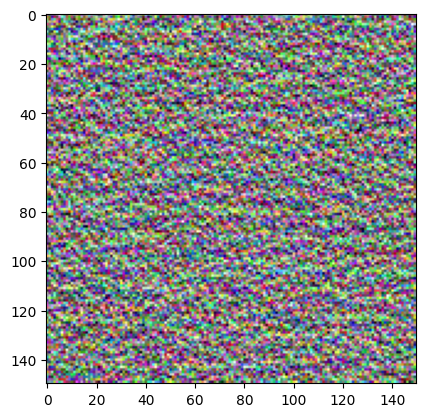

In [140]:
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

The filters in these convnet filter banks get increasingly complex and refined as you go deeper in the model:
- The filters from the first layers in the model encode simple directional edges and colors (or colored edges, in some cases).
- The filters from layers a bit further up the stack, such as block4_sepconv1, encode simple textures made from combinations of edges and colors.
- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on. 

### Visualizing heatmaps of class activation
This method is useful for understanding which parts of a given image led a convnet to its final classification decision.
This is helpful for “debugging” the decision process of a convnet, particularly in the case of a classification mistake (a problem domain called model interpretability).

It is called **class activation map (CAM) visualization**

**Grad-CAM** consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. 

In [143]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [144]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")


def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)  # add batch 
    array = keras.applications.xception.preprocess_input(array)  # preprocess to work with xception 
    return array


img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [145]:
preds = model.predict(img_array)  # predict the image
keras.applications.xception.decode_predictions(preds, top=3)[0]  # print the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
[('n02504458', 'African_elephant', 0.8699397), ('n01871265', 'tusker', 0.07695618), ('n02504013', 'Indian_elephant', 0.023541754)]


In [146]:
# To visualize which parts of the image are the most African-elephant–like, let’s set up the Grad-CAM process.
# First, we create a model that maps the input image to the activations of the last convolutional layer.
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [157]:
# Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.
# By sequentially passing x through each layer in classifier_layer_names, you're constructing a new model (classifier_model) that mimics the behavior of model but only includes the specified layers.
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [149]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [150]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

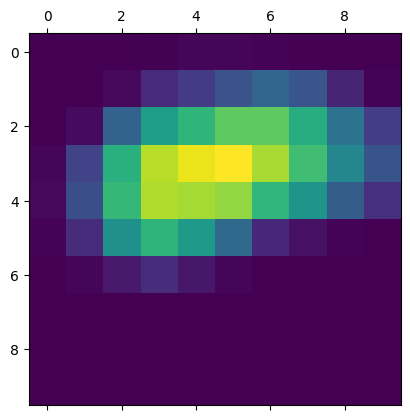

In [151]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [153]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)                                

/var/folders/by/tj028j115v58k1r17jkmbr5c0000gq/T/ipykernel_37647/2145631631.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
